<a href="https://colab.research.google.com/github/JihyeLimm/Quest/blob/main/Quest5/Ex10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#10. 인물사진을 만들어 보자 [프로젝트]

1. 인물모드 사진을 성공적으로 제작하였다.	
>아웃포커싱 효과가 적용된 인물모드 사진과 동물 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.
2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.	
>인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.
3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.	
>semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 이유와 함께 제시하였다.


In [1]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount = True)
os.chdir("/gdrive/MyDrive/AIFFEL/230524")
os.getcwd()

Mounted at /gdrive


'/gdrive/MyDrive/AIFFEL/230524'

라이브러리 준비

In [ ]:
!pip install pixellib

import fileinput

# Define the path to the file that needs to be modified
FILE_PATH = "/usr/local/lib/python3.10/dist-packages/pixellib/semantic/deeplab.py"

# Define the old and new strings that need to be replaced
OLD_STRING = "tensorflow.python.keras"
NEW_STRING = "tensorflow.keras"

# Use fileinput to replace the old string with the new string in the file
for line in fileinput.input(FILE_PATH, inplace=True):
    print(line.replace(OLD_STRING, NEW_STRING), end='')

# Define the old and new strings that need to be replaced
# This handles model loading errors
OLD_STRING = "tensorflow.keras.utils.layer_utils import get_source_inputs"
NEW_STRING = "tensorflow.python.keras.utils.layer_utils import get_source_inputs"

# Use fileinput to replace the old string with the new string in the file
for line in fileinput.input(FILE_PATH, inplace=True):
    print(line.replace(OLD_STRING, NEW_STRING), end='')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [10]:
import urllib
import cv2   # cv2: OpenCV 라이브러리로, 실시간 컴퓨터 비전을 목적으로 한 프로그래밍 라이브러리
import numpy as np
import pixellib   # pixellib: 이미지 및 비디오 segmentation을 수행하기 위한 라이브러리
from pixellib.semantic import semantic_segmentation   #semantic segmentation을 쉽게 사용할 수 있도록 만든 라이브러리
from matplotlib import pyplot as plt

#1. 인물모드 사진과 동물 사진, 배경전환 크로마키사진 제작

In [11]:
#데이터 로드
my_path = "/gdrive/MyDrive/AIFFEL/230524/images/my.png"
dog_path = "/gdrive/MyDrive/AIFFEL/230524/images/dog.png"
bg_path = "/gdrive/MyDrive/AIFFEL/230524/images/rainbow.png"

1.인물모드

(1962, 1125, 3)


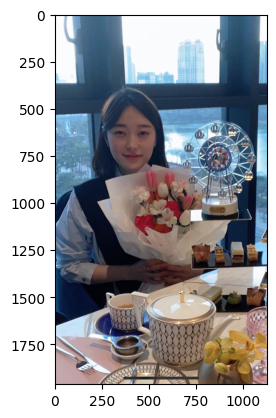

In [12]:
my_orig = cv2.imread(my_path) 
print(my_orig.shape)

plt.imshow(cv2.cvtColor(my_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
#PixelLib모델 다운로드 및 모델 생성

model_dir = "/gdrive/MyDrive/AIFFEL/230524/models"
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
#model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
#urllib.request.urlretrieve(model_url, model_file) 

model = semantic_segmentation() 
model.load_pascalvoc_model(model_file) 

#pascalvoc 데이터의 라벨종류:background를 제외하면 20개의 클래스
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

1/1 [==============================] - 7s 7s/step


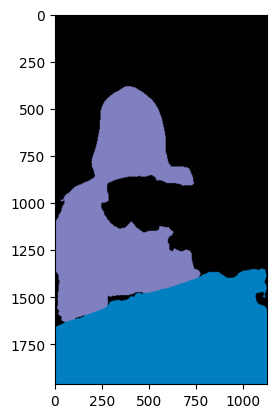

background
diningtable
person
[192 128 128]


In [25]:
#모델에 데이터 적용
segvalues, output = model.segmentAsPascalvoc(my_path) 

plt.imshow(output)
plt.show()

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])   #background, diningtable, person

#output에 어떤 색상으로 나타나 있는지 확인
#컬러맵 만들기
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력 -> 생상 코드 결과물

#사람을 나타내는 15번째 색상 확인: colormap[class_id]
print(colormap[15]) #컬러맵 15에 해당하는 배열 출력 ->[192 128 128]

# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치
seg_color = (128,128,192)

(1962, 1125)


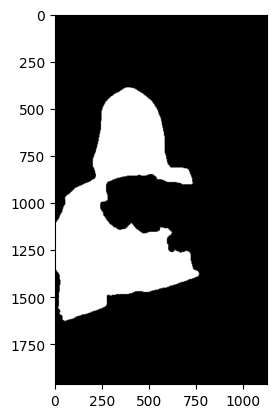

In [26]:
#seg_color로만 이루어진 마스크 만들기
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()   #3채널 가졌던 원본과는 다르게 채널 정보가 사라짐 

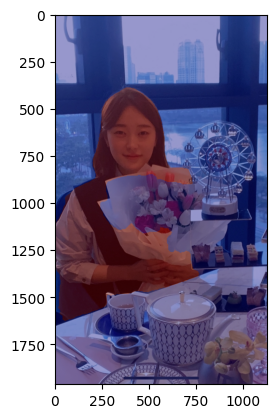

In [27]:
# 원본이미지를 my_showw에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
my_show = my_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
my_show = cv2.addWeighted(my_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(my_show, cv2.COLOR_BGR2RGB))
plt.show()

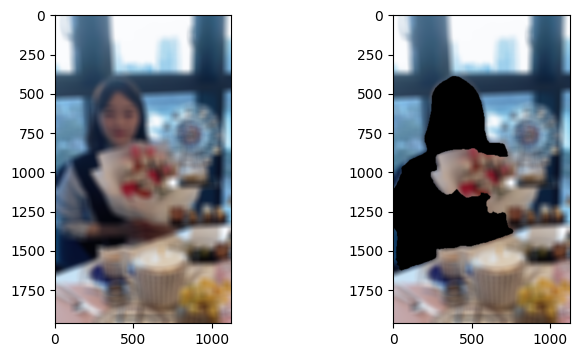

In [35]:
#배경흐리게 하기
my_orig_blur = cv2.blur(my_orig, (50,50)) # (50, 50)은 blurring kernel size -> 숫자가 클수록 흐릿

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(my_orig_blur, cv2.COLOR_BGR2RGB))

#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
plt.subplot(1,2,2)
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) #cv2.bitwise_not(): 이미지가 반전
img_bg_blur = cv2.bitwise_and(my_orig_blur, img_bg_mask)  #bitwise_and: 배경만 남음
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

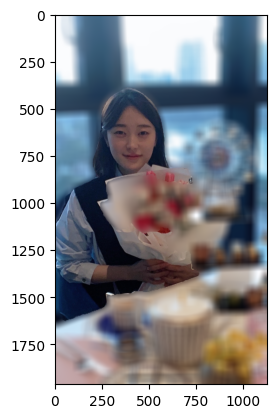

In [36]:
#흐린배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, my_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

2.강아지모드

(513, 785, 3)


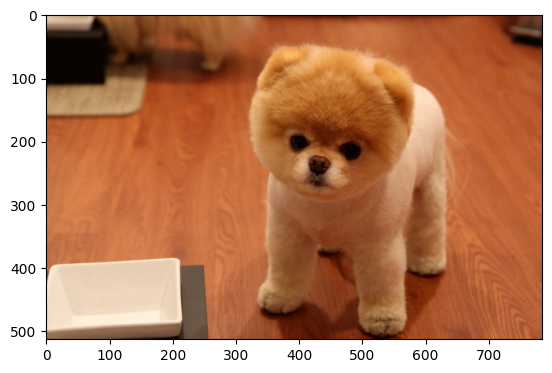

In [37]:
#데이터 확인
my_orig = cv2.imread(dog_path) 
print(my_orig.shape)
plt.imshow(cv2.cvtColor(my_orig, cv2.COLOR_BGR2RGB))
plt.show()

1/1 [==============================] - 10s 10s/step


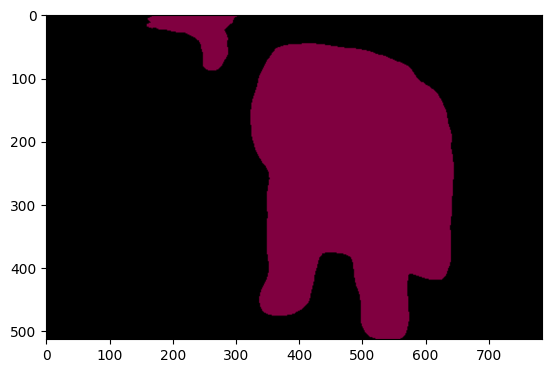

background
dog
[ 64   0 128]


In [41]:
#모델에 데이터 적용
segvalues, output = model.segmentAsPascalvoc(dog_path) 

plt.imshow(output)
plt.show()

for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])   #background, dog

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

#dog 나타내는 12번째 색상 확인: colormap[class_id]
print(colormap[12]) #컬러맵 12에 해당하는 배열 출력 ->[ 64   0 128]

# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치
seg_color = (128,0,64)

(513, 785)


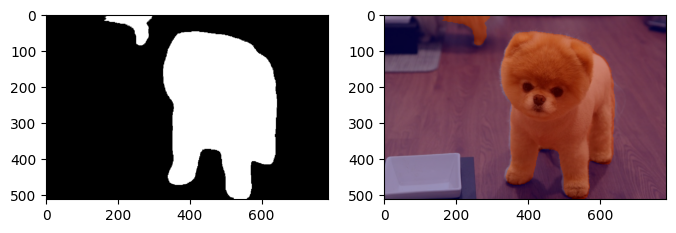

In [42]:
#seg_color로만 이루어진 마스크 만들기
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(seg_map, cmap='gray')  #3채널 가졌던 원본과는 다르게 채널 정보가 사라짐 

# 원본이미지를 my_showw에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
my_show = my_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
my_show = cv2.addWeighted(my_show, 0.6, color_mask, 0.4, 0.0)
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(my_show, cv2.COLOR_BGR2RGB))
plt.show()

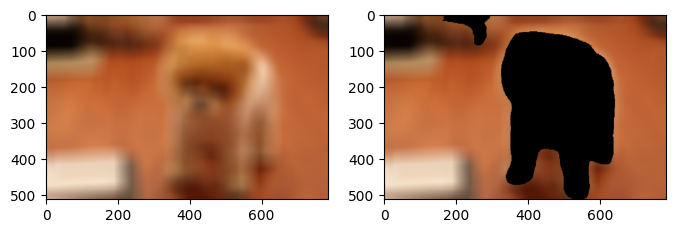

In [43]:
#배경흐리게 하기
my_orig_blur = cv2.blur(my_orig, (50,50)) # (50, 50)은 blurring kernel size -> 숫자가 클수록 흐릿

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(my_orig_blur, cv2.COLOR_BGR2RGB))

#흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출
plt.subplot(1,2,2)
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) #cv2.bitwise_not(): 이미지가 반전
img_bg_blur = cv2.bitwise_and(my_orig_blur, img_bg_mask)  #bitwise_and: 배경만 남음
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

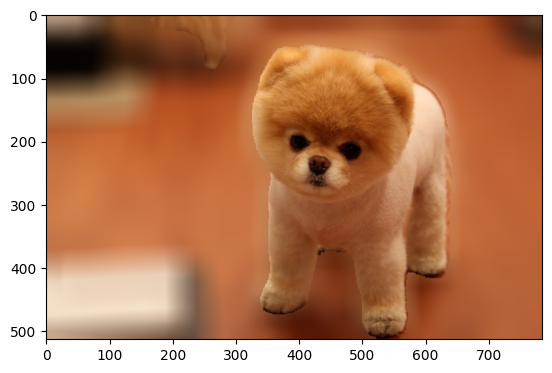

In [44]:
#흐린배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, my_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

3. 크로마키사진

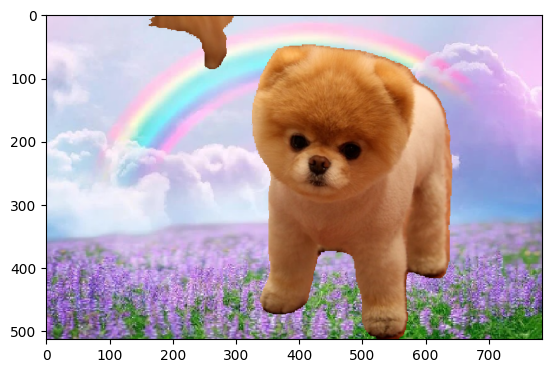

In [53]:
#다른배경과 원본 영상 합성 => 다른 강아지 뒷발이 함께 나타났습니다ㅠ

new_bg = cv2.imread(bg_path) 
new_bg = cv2.blur(new_bg, (1, 1))
img_concat = np.where(img_mask_color==255, my_orig, new_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

#2. 제작한 인물모드 사진들에서 나타나는 문제점

> 손과연결되어 있는 꽃다발 아래부분도 사람으로 인식

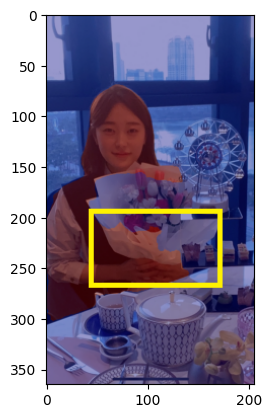

In [59]:
my_error = cv2.imread("/gdrive/MyDrive/AIFFEL/230524/images/my_error.png") 
plt.imshow(cv2.cvtColor(my_error, cv2.COLOR_BGR2RGB))
plt.show()

#3. 해결방법
>컨투어 단순화
(예:  cv2.approxPolyDP() 등)

제 샘플사진을 보면 손부분이 어두워서 꽃다발의 밑(그늘진)부분과 구분이 잘 되지 않는걸로 생각이 듭니다
따라서 명도를 조절한 샘플을 함께 쓰거나, 노이즈가 있는 샘플을 함께 사용해 
컨투어단순화를 통해 인식률을 좀 더 높일 수 있을 것 같습니다
